# Wikipedia Analysis

It is necessary to perform an EDA activity to statistically analyze and evaluate all the information content offered by Wikipedia. The bump you are provided with, has the following categories: 
* 'culture',
* 'economics',
* 'energy',
* 'engineering',
* 'finance',
* 'humanities',
* 'medicine',
* 'pets',
* 'politics',
* 'research',
* 'science',
* 'sports',
* 'technology',
* 'trade',
* 'transport'

Let load the dataset, save it into a table and breafly analyse it.

In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
import pandas as pd
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')
spark_df = spark.createDataFrame(dataset)
spark_df = spark_df.drop("Unnamed: 0")

--2024-08-27 13:16:09--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.156.60, 52.95.156.52
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.156.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘wikipedia.csv’

wikipedia.csv       100%[===================>] 956.99M  15.2MB/s    in 70s     

2024-08-27 13:17:20 (13.6 MB/s) - ‘wikipedia.csv’ saved [1003477941/1003477941]



In [0]:
spark_df.write.saveAsTable("wikipedia_8")

We can see that the dataset consists of 4 columns:
* Title: the title of the documents
* Summary: the summary of the documents
* Documents: the information content
* Category: the document category, which is one of the categories listed above.

In [0]:
spark_df.show(10)

+--------------------+--------------------+--------------------+---------+
|               title|             summary|           documents|categoria|
+--------------------+--------------------+--------------------+---------+
|           economics|economics () is a...|economics () is a...|economics|
|index of economic...|this aims to be a...|this aims to be a...|economics|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|economic impact a...|an economic impac...|an economic impac...|economics|
|      economic trend|economic trend ma...|economic trend ma...|economics|
|    entrepreneurship|entrepreneurship ...|entrepreneurship ...|economics|
|    factor investing|factor investing ...|factor investing ...|economics|
|          filtering |in housing econom...|in housing econom...|economics|
|          free trade|free trade is a t...|free trade is a t...|economics|
|         liquidation|liquidation is th...|liquidation is th...|economics|
+--------------------+---

## EDA
Let begin watching the number of documents in the dataset, and try to remove rows with missing parameters if any.

In [0]:
display(spark_df.count())

153232

In [0]:
spark_df = spark_df.dropna()
display(spark_df.count())

152304

We observe that the database is composed of a list of 153232 documents, where 152304 are useful for our purpose, since others present some void field. <br>
For the EDA, we concentrate on the column category and we compute some statistics on it, for example the number of articles for each category, the average number of words, the longest and the shortest document (where longest and shortest refer to the number of words).
These steps are computed through the use of SQL, querying the "default" database of the Databricks cluster we generated where our table was previously stored.


#### 1. Number of articles

In [0]:
%sql

select categoria, 
count(*) as articles_number
from default.wikipedia_8
group by 1
order by 1

categoria articles_number culture 10372 economics 10110 energy 10046 engineering 10220 finance 10157 humanities 10236 medicine 10076 pets 10023 politics 11358 research 10037 science 10236 sports 10068 technology 10095 trade 10068 transport 10130

From this query, we can notice that the dataset is balanced, since for each category the number of articles is very similar. In fact from 9863 documents for finance we reach at maximum 11358 for politics.

#### 2. Average number of words used (for each category)


To compute this second task and the following, we can exploit the tokenization.
For each row, using the RDD, we can create a new table which contain the category and the number of words, computed by counting the number of tokens for each document.

In [0]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import length
from pyspark.sql.types import Row

tokenizer = Tokenizer(inputCol="documents", outputCol="token_documents")
df_tokens = tokenizer.transform(spark_df).drop("title", "summary", "documents")
display(df_tokens.head(5))

categoria token_documents economics List(economics, (), is, a, social, science, that, studies, the, production,, distribution,, and, consumption, of, goods, and, services.economics, focuses, on, the, behaviour, and, interactions, of, economic, agents, and, how, economies, work., microeconomics, analyzes, what's, viewed, as, basic, elements, in, the, economy,, including, individual, agents, and, markets,, their, interactions,, and, the, outcomes, of, interactions., individual, agents, may, include,, for, example,, households,, firms,, buyers,, and, sellers., macroeconomics, analyzes, the, economy, as, a, system, where, production,, consumption,, saving,, and, investment, interact,, and, factors, affecting, it:, employment, of, the, resources, of, labour,, capital,, and, land,, currency, inflation,, economic, growth,, and, public, policies, that, have, impact, on, these, elements., other, broad, distinctions, within, economics, include, those, between, positive, economics,, describing, "what, is",, and, normative, economics,, advocating, "what, ought, to, be";, between, economic, theory, and, applied, economics;, between, rational, and, behavioural, economics;, and, between, mainstream, economics, and, heterodox, economics.economic, analysis, can, be, applied, throughout, society,, including, business,, finance,, cybersecurity,, health, care,, engineering, and, government., it, is, also, applied, to, such, diverse, subjects, as, crime,, education,, the, family,, feminism,, law,, philosophy,, politics,, religion,, social, institutions,, war,, science,, and, the, environment., definitions, of, economics, over, time, the, earlier, term, for, the, discipline, was, 'political, economy',, but, since, the, late, 19th, century,, it, has, commonly, been, called, 'economics'., the, term, is, ultimately, derived, from, ancient, greek, οἰκονομία, (oikonomia), which, is, a, term, for, the, "way, (nomos), to, run, a, household, (oikos)",, or, in, other, words, the, know-how, of, an, οἰκονομικός, (oikonomikos),, or, "household, or, homestead, manager"., derived, terms, such, as, "economy", can, therefore, often, mean, "frugal", or, "thrifty"., by, extension, then,, "political, economy", was, the, way, to, manage, a, polis, or, state., there, are, a, variety, of, modern, definitions, of, economics;, some, reflect, evolving, views, of, the, subject, or, different, views, among, economists., scottish, philosopher, adam, smith, (1776), defined, what, was, then, called, political, economy, as, "an, inquiry, into, the, nature, and, causes, of, the, wealth, of, nations",, in, particular, as:, a, branch, of, the, science, of, a, statesman, or, legislator, [with, the, twofold, objectives, of, providing], a, plentiful, revenue, or, subsistence, for, the, people, ..., [and], to, supply, the, state, or, commonwealth, with, a, revenue, for, the, publick, services., jean-baptiste, say, (1803),, distinguishing, the, subject, matter, from, its, public-policy, uses,, defined, it, as, the, science, of, production,, distribution,, and, consumption, of, wealth., on, the, satirical, side,, thomas, carlyle, (1849), coined, "the, dismal, science", as, an, epithet, for, classical, economics,, in, this, context,, commonly, linked, to, the, pessimistic, analysis, of, malthus, (1798)., john, stuart, mill, (1844), delimited, the, subject, matter, further:, the, science, which, traces, the, laws, of, such, of, the, phenomena, of, society, as, arise, from, the, combined, operations, of, mankind, for, the, production, of, wealth,, in, so, far, as, those, phenomena, are, not, modified, by, the, pursuit, of, any, other, object., alfred, marshall, provided, a, still, widely, cited, definition, in, his, textbook, principles, of, economics, (1890), that, extended, analysis, beyond, wealth, and, from, the, societal, to, the, microeconomic, level:, economics, is, a, study, of, man, in, the, ordinary, business, of, life., it, enquires, how, he, gets, his, income, and, how, he, uses

In [0]:
df_numb_words = df_tokens.rdd.map(
    lambda x: Row(x['categoria'], len(x['token_documents']))
        ).toDF(schema=['categoria', 'words_number'])

In [0]:
avg_words_number = df_numb_words.groupBy('categoria').avg('words_number').orderBy(2, ascending=False)
display(avg_words_number)

categoria avg(words_number) finance 1909.892426239481 science 1875.616171552233 politics 1515.6516992428244 humanities 1059.7318109924872 economics 984.2049455984175 technology 889.2349732195993 medicine 792.1511732401398 engineering 725.1148840395342 research 701.8601208459214 culture 653.8663712456918 trade 641.1518282988872 transport 629.7859756700623 sports 602.1093781045103 energy 587.4513106747733 pets 423.1049321086262

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

def add_bar_value(ax, bars):
    '''
    Annotates each bar in a bar plot with its height value.
    
    ax : matplotlib.axes.Axes
        The axes object containing the bar plot to be annotated.
    bars : list of matplotlib.patches.Rectangle (seaborn.barplot)
        A list of bars (rectangles) in the bar plot, which can be accessed using
        `ax.patches` or the return value of a Seaborn barplot.
    '''
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.0f}', 
                ha='center', va='bottom')

def create_bar_plot(table, x:str, y:str, title=None, color:str='skyblue'):
    '''
    Create a barplot
    
    table: pandas.Dataframe
    x: dataframe column name representing the x axis
    y: dataframe column name representing the y axis
    title: optional title
    color: optional color. If not specified skyblue is selected
    '''
    _, ax = plt.subplots(figsize=(12,7))
    barplt = sns.barplot(table, x=x, y=y, color=color)
    ax.tick_params(axis='x', rotation=30)
    add_bar_value(ax, barplt.patches)
    ax.spines[['top', 'right']].set_visible(False)
    if title:
        ax.set_title(title)
    plt.subplots_adjust(hspace=0.3)



We represent the table through a barplot, maintaining the same order of the table, from the category with the highest average number of words, to the one with the shortest.

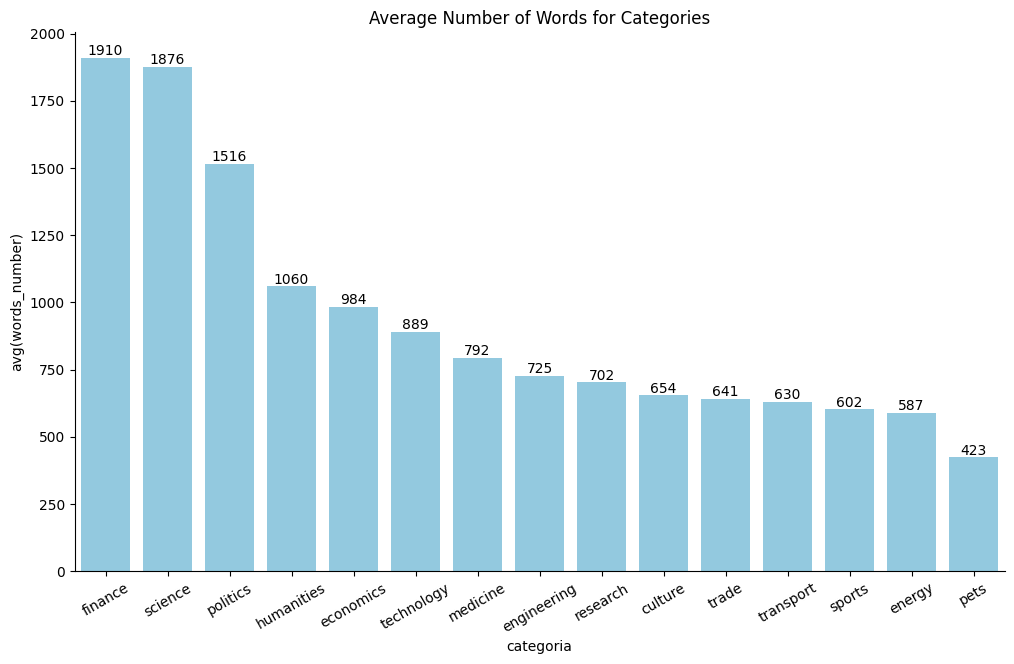

In [0]:
avg_words_number_df = avg_words_number.toPandas()
create_bar_plot(avg_words_number_df, "categoria", 'avg(words_number)', title="Average Number of Words for Categories")

Differently from the previous case, this time some differences between categories appear. In fact finance articles are on average 1500 words longer than pets documents. <br>
In the first three positions, as we could expect we have finance, science and politics respectively.

#### 3. Maximum number of words in the longest article


In [0]:
max_words_number = df_numb_words.groupBy('categoria').max('words_number').orderBy(2, ascending=False)
display(max_words_number)

categoria max(words_number) finance 33479 science 29419 research 27223 economics 24022 energy 23223 humanities 23198 transport 22150 politics 20140 trade 19275 sports 19227 medicine 18422 technology 18144 culture 15538 pets 13222 engineering 11856

Let see graphically what this table means.

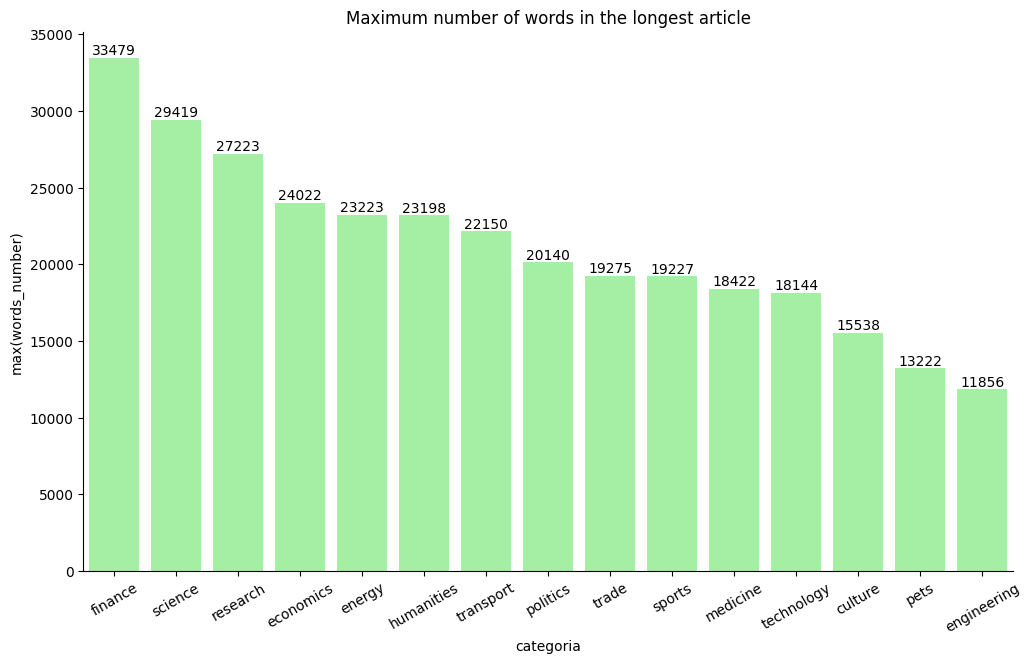

In [0]:
max_words_number_df = max_words_number.toPandas()
create_bar_plot(max_words_number_df, "categoria", 'max(words_number)', title="Maximum number of words in the longest article", color='palegreen')

The maximum number of words, is reached by a finance document, followed by science and research. Politics, that was third considering the average number of words, in this case is eighth.
<br> The longest engineering article has approximately 21000 words less than the finance one.

#### 4. Minimum number of words in the shortest article

Finally the minimum number of words, is reached by technology, followed by finance and humanities.

In [0]:
min_words_number = df_numb_words.groupBy('categoria').min('words_number').orderBy(2)
display(min_words_number)

categoria min(words_number) technology 2 finance 3 humanities 7 engineering 8 energy 9 economics 10 transport 10 politics 11 culture 11 pets 12 medicine 12 sports 14 science 15 trade 16 research 17

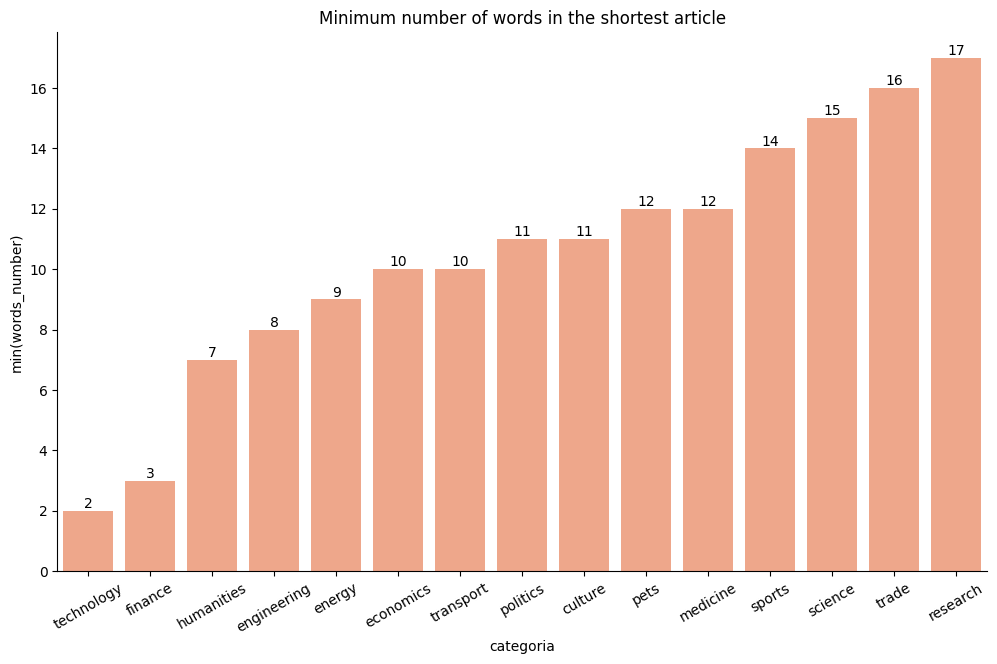

In [0]:
min_words_number_df = min_words_number.toPandas()
create_bar_plot(min_words_number_df, "categoria", 'min(words_number)', title="Minimum number of words in the shortest article", color='lightsalmon')

The category which present a document with the minimum number of words is technology with 2 words, followed by finance with 3 and humanities with 7 words. <br>
For research, the sortest document presents only 17 words. 

#### 5. Cloud words for each category

In order to compute che cloud words for each category, we need to install *nltk* and *sparknlp* packages. The first is needed to load english dictionary and stopwords, the second to perform NLP tasks, such as tokenization, lemmatization, stopwords removal and so on.
Package *sparknlp* also requires to install a library, which is **com.johnsnowlabs.nlp:spark-nlp_2.12:5.4.1** in our case.

In [0]:
%pip install nltk
%pip install sparknlp

  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/4d/66/7d9e26593edda06e8cb531874633f7c2372279c3b0f46235539fe546df8b/nltk-3.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/8b/77/92d4a14530900d46dddc57b728eea65d723cc9fcfd07b96c2c141dabba84/regex-2024.7.24-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/40.5 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.7 MB/s eta 0:00:00
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/48/5d/acf5905c36149bbaec41ccf7f2b68814647347b72075ac0b1fe3022fdc73/tqdm-4.66.5-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/57.6 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.5 MB ? e

We create our pipeline to preprocess the text in this way:
- **DocumentAssembler**: processes data in order to operate with *sparknlp*
- **Tokenizer**: tokenizes the given documents
- **Normalizer**: removes all dirty characters from text following a regex pattern and transforms words based on a provided dictionary 
- **StopWordsCleaner**: cleans tokens from stopwords
- **LemmatizerModel**: computes lemmatization on tokens
- **Finisher**: converts annotation results into a format that easier to use.

In [0]:
import nltk
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner, LemmatizerModel
from pyspark.ml import Pipeline

nltk.download("stopwords")
eng_stopwords = nltk.corpus.stopwords.words('english')

# sparknlp requires com.johnsnowlabs.nlp:spark-nlp_2.12:5.4.1
#from a reinterpretation of https://sparknlp.org/api/python/reference/autosummary/sparknlp/base/embeddings_finisher/index.html

doc_assembler = DocumentAssembler()\
    .setInputCol('documents')\
    .setOutputCol('ass_docs')
tokenizer = Tokenizer()\
    .setInputCols('ass_docs')\
    .setOutputCol('tokens')
# Normalizer removes all dirty characters from text following a regex pattern and transforms words based on a provided dictionary 
normalizer = Normalizer()\
    .setInputCols('tokens')\
    .setOutputCol('norm_tokens')
stopwords_cleaner = StopWordsCleaner()\
    .setInputCols('norm_tokens')\
    .setOutputCol('clean_tokens')\
    .setStopWords(eng_stopwords)
lemmatizer = LemmatizerModel().pretrained()\
    .setInputCols('clean_tokens')\
    .setOutputCol('lemmatized_tokens')
#Finisher converts annotation results into a format that easier to use.
finisher = Finisher()\
    .setInputCols('lemmatized_tokens')\
    .setOutputCols(['docs_tokens'])\
    .setCleanAnnotations(False)

clean_df_pipeline = Pipeline()\
    .setStages([
        doc_assembler,
        tokenizer,
        normalizer,
        stopwords_cleaner,
        lemmatizer,
        finisher
    ]).fit(spark_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


We can observe the result on our dataset:

In [0]:
cleaned_df = clean_df_pipeline.transform(spark_df)
display(cleaned_df.show(5))

+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               title|             summary|           documents|categoria|            ass_docs|              tokens|         norm_tokens|        clean_tokens|   lemmatized_tokens|         docs_tokens|
+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           economics|economics () is a...|economics () is a...|economics|[{document, 0, 69...|[{token, 0, 8, ec...|[{token, 0, 8, ec...|[{token, 0, 8, ec...|[{token, 0, 8, ec...|[economics, socia...|
|index of economic...|this aims to be a...|this aims to be a...|economics|[{document, 0, 11...|[{token, 0, 3, th...|[{token, 0, 3, th...|[{token, 5, 8, ai...|[{token, 5, 8, ai...|[aim, complete, a

Now, to be able to exploit *pyspark* for querying the obtained dataframe, we create a temporary table we call *"cleaned_df_tokens"*.

In [0]:
cleaned_df.createOrReplaceTempView('cleaned_df_tokens')

In [0]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/40/ad/c22887189c23cc133ae7cbad48c71312f1a962b960fe7f51fd792808a307/wordcloud-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/548.3 kB ? eta -:--:--
   ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/548.3 kB 4.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 8.0 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from wordcloud import WordCloud

def get_cloud_words(category):
    sql_cloud_words = spark.sql(
       f"""select token, count(*) as count 
        from (select explode(docs_tokens) as token
        from cleaned_df_tokens
        where categoria = '{category}')
        group by 1
        order by 2 desc"""
    )
    
    word_counts = sql_cloud_words.collect()
    word_count_dict = {row['token']: row['count'] for row in word_counts}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count_dict)
    return wordcloud

def show_cloud_words(wordclouds, category_list):
    _, ax = plt.subplots(5, 3, figsize=(22, 22))
    ax = ax.flatten()
    for i, cat in enumerate(category_list):
        ax[i].imshow(wordclouds[i], interpolation='bilinear')
        ax[i].axis('off')
        ax[i].set_title(cat.upper())

    for j in range(len(category_list), len(ax)):
        ax[j].axis('off')
        plt.tight_layout()
        plt.show()
    

In [0]:
distinct_categories = cleaned_df.select("categoria").distinct().collect()
category_list = [row['categoria'] for row in distinct_categories]
cat_number = len(category_list)

Let compute the words cloud for each category. Since the process requires a lot of time, we split the computation in five chuncks. 

In [0]:
%matplotlib inline
word_clouds = []
for cat in category_list[0:cat_number//5]:
    word_clouds.append(get_cloud_words(cat))


In [0]:
for cat in category_list[cat_number//5:2*cat_number//5]:
    word_clouds.append(get_cloud_words(cat))

In [0]:
for cat in category_list[cat_number*2//5:cat_number*3//5]:
    word_clouds.append(get_cloud_words(cat))

In [0]:
for cat in category_list[cat_number*3//5:cat_number*4//5]:
    word_clouds.append(get_cloud_words(cat))

In [0]:
for cat in category_list[cat_number*4//5:]:
    word_clouds.append(get_cloud_words(cat))

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:729)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:447)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

Let see the result we obtain:

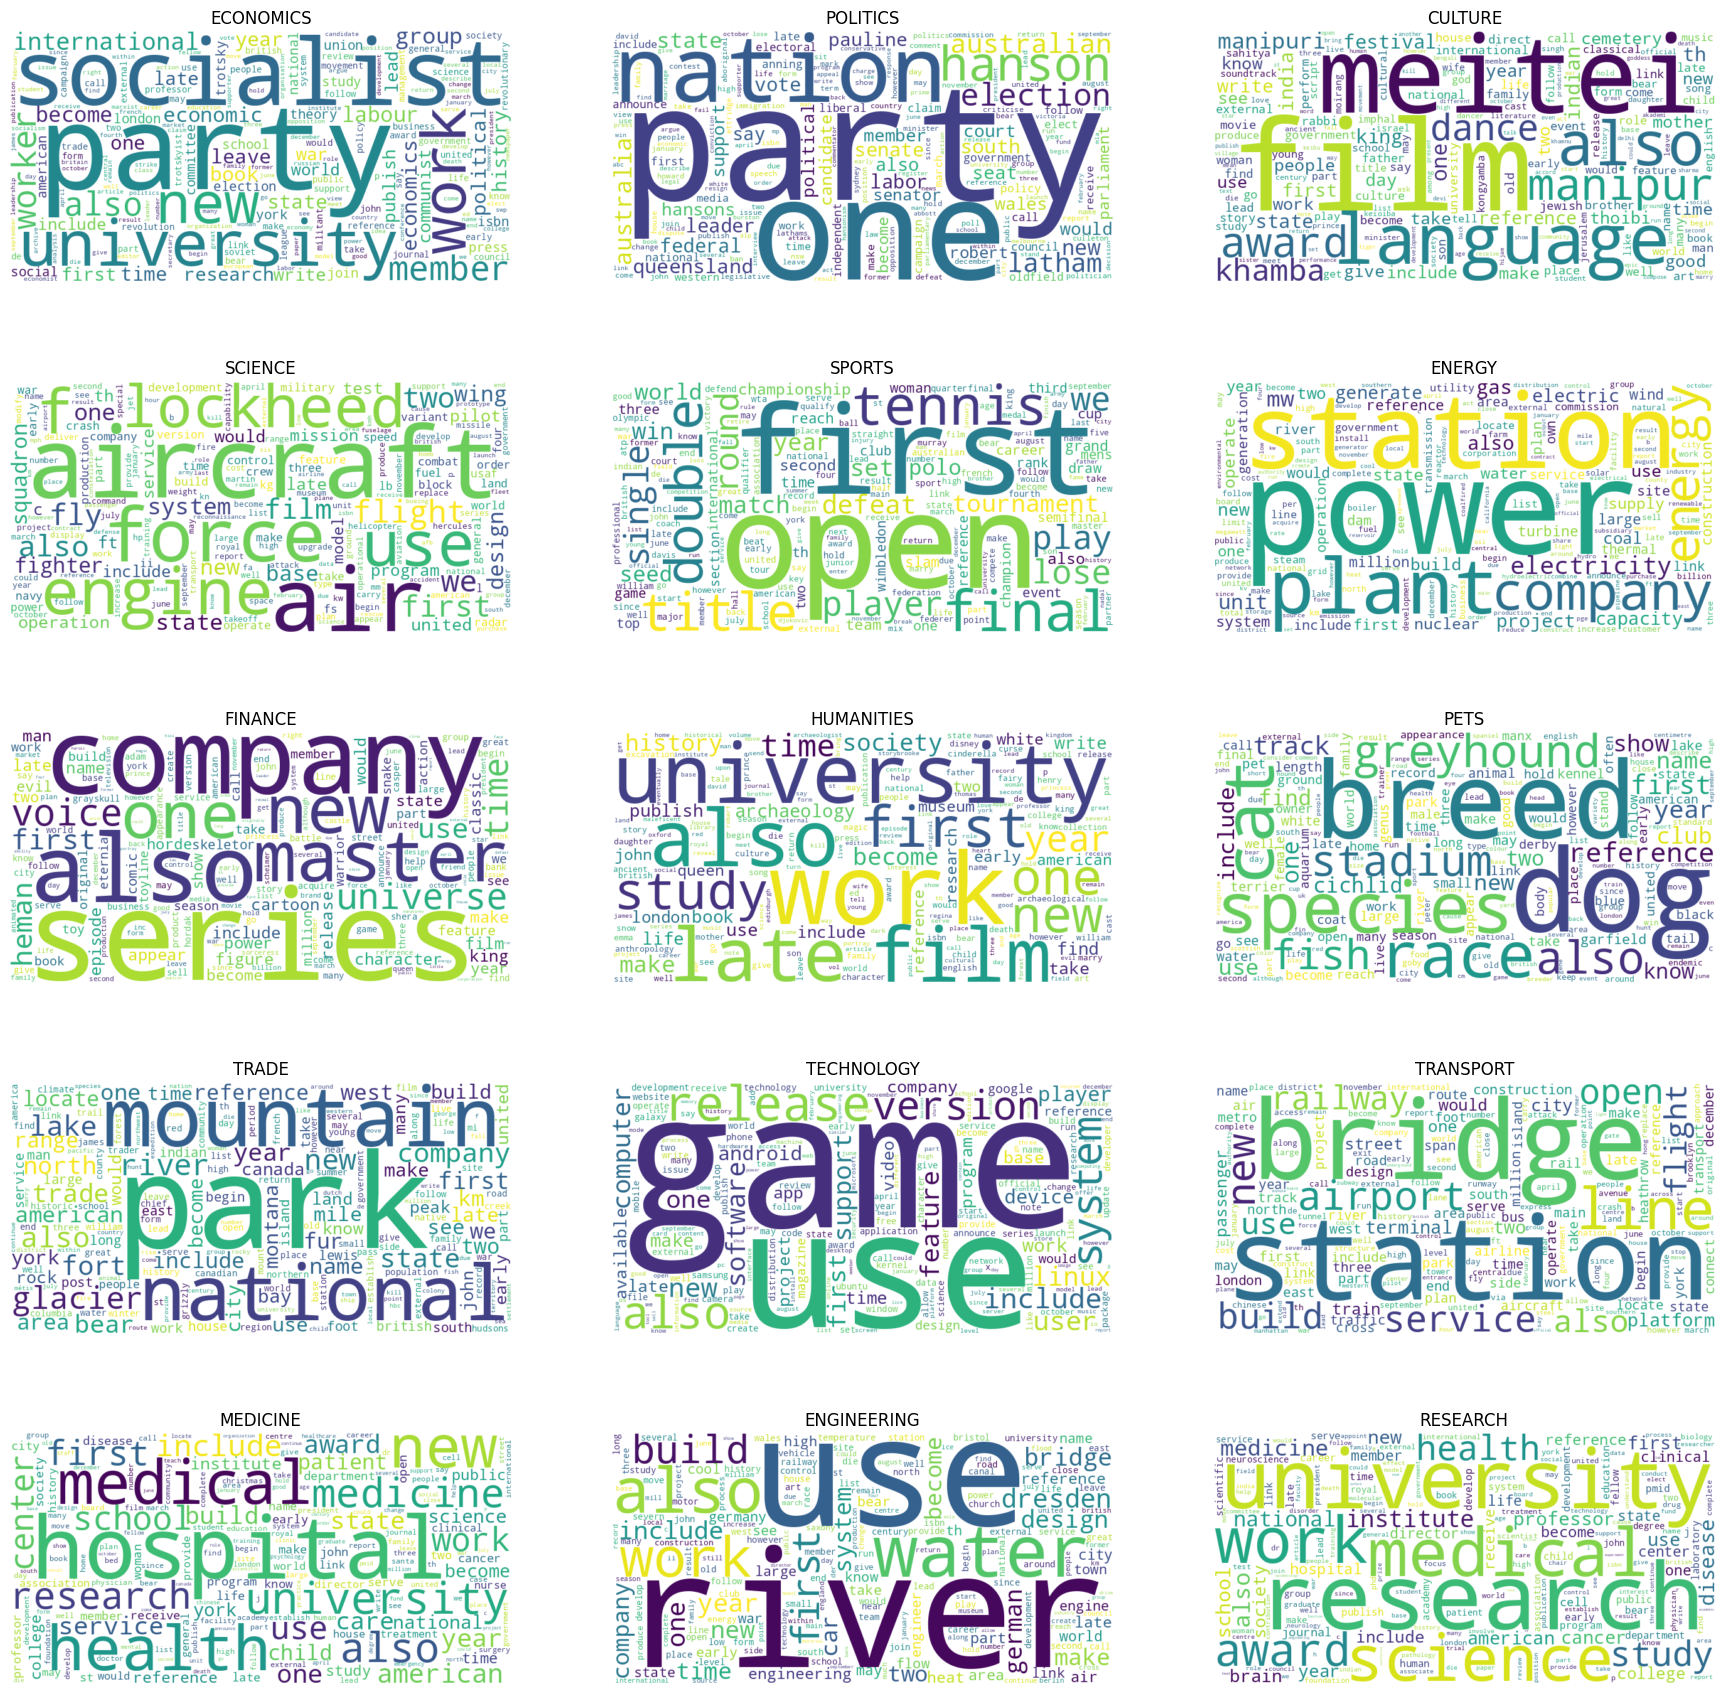

In [0]:
show_cloud_words(word_clouds, category_list)

From the word clouds, we can see the words that appear the most in documents, where the bigger and thicker the word, the greater its frequency.
We can notice that for **economics** and **politics**, party represents an high frequency word or that in **technology** "game" is definetely the widest used.<br>
In **medicine** and **research**, many words are commonly used, while for **transport** "bridge" and "station" compete for the role of most frequently used word.

## Classification model
Once computed the EDA, we can deal with the second part of the project, which consists on create a classification model in order to correctly classify documents, both given their contents and given their summary.
To avoid problems with computation time and resources reported by many students, we decide to train the classification model on the 45% of the entire dataset, and the split the ramaining into a train, validation and test set (respectively 60%, 20% and 20% of the remaining). 

In [0]:
keep_df, discard_df = spark_df.randomSplit([.45, .55], seed=0)
train, validation, test = keep_df.randomSplit([.6, .2, .2], seed=0)

Another important thing to do is to vectorize the tokens before performing any model to the dataset. We decide to use the TF-IDF method, where the term frequency is computed by mapping a sequence of terms using the hashing trick.

In [0]:
from pyspark.ml.feature import StringIndexer, HashingTF, IDF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

hashing_tf = HashingTF(inputCol="docs_tokens", outputCol="raw_features", numFeatures=15000)
idf = IDF(inputCol="raw_features", outputCol="features")

In [0]:
encoder_vec = StringIndexer(inputCol="categoria", outputCol="label")

One of the most efficient methods for classification is the Naive Bayes algorithm, which is based on the Bayes theorem. The reason why we chose it is because of its quick classification, even if it is usually used for sentiment analysis and spam filtering. In this case it will be used for the classification of documents.

In [0]:
naive_bayes = NaiveBayes(featuresCol='features', labelCol='label')

In [0]:
process_pipeline = Pipeline()\
    .setStages([
        doc_assembler,
        tokenizer,
        normalizer,
        stopwords_cleaner,
        lemmatizer,
        finisher,
        encoder_vec,
        hashing_tf,
        idf,
        naive_bayes
    ])

We create the pipeline, and then, as we can see following, we train our model first for summaries, also computing the fine tuning of some hyperparameters on the validation set.
Once we find the best parameters, we use them to classify on test set.
The two hyperparameters we fine tune are:
* smoothing which is an important parameter to avoid the zero probability in Naive Bayes. It should be a value greater than 0, and we chose to try 3 different values: 0.5, 0.75 and 1 (which is the default value).
* model type: we chose between complement and multinomial. Complement Naive Bayes is an adaptation of the Multinomial Naive Bayes which  uses statistics from the complement of each class to compute the model’s coefficients.

We also repeat all the preprocessing steps, but maintaining the dataset splitted on train, validation and test set, in order to avoid data leakage.


### Summary

In [0]:
doc_assembler.setInputCol('summary')
evaluator = MulticlassClassificationEvaluator(labelCol="label")
smooth = [.5, .75, 1.0]
model_type = ['complement', 'multinomial']

best_eval = [0, (0, None)]
for smt in smooth:
  naive_bayes.setSmoothing(smt)
  for md in model_type:
    naive_bayes.setModelType(md)
    model = process_pipeline.fit(train)
    validation_predictions = model.transform(validation)
    f1_score = evaluator.evaluate(validation_predictions)
    print(f"Smoothing: {smt}, Model Type: {md}\nF1 score obtained {f1_score}")
    if f1_score > best_eval[0]:
      best_eval[0] = round(f1_score, 3)
      best_eval[1] = (smt, md)

Smoothing: 0.5, Model Type: complement
F1 score obtained 0.8454270580302439
Smoothing: 0.5, Model Type: multinomial
F1 score obtained 0.857037258366866
Smoothing: 0.75, Model Type: complement
F1 score obtained 0.8455259813044157
Smoothing: 0.75, Model Type: multinomial
F1 score obtained 0.8592761575591683
Smoothing: 1.0, Model Type: complement
F1 score obtained 0.8458885392567772
Smoothing: 1.0, Model Type: multinomial
F1 score obtained 0.8606600995683747


After training the model, we can see that the default values for Naive Bayes (smoothing equal to 1.0 and modelType set to multinomial), are the best hyperparameters for this dataset. <br>
The f1-score on the validation set is 0.861, which represent a good performance and a good balance between precision and recall. 

In [0]:
best_eval 

[0.861, (1.0, 'multinomial')]

In [0]:
naive_bayes.setSmoothing(1.0)
naive_bayes.setModelType('multinomial')

NaiveBayes_4b5b0e6a7bae

Let set the hyperparameters, and test our model on the test set:

In [0]:
test_predictions = model.transform(test)

In [0]:
test_accuracy = evaluator.evaluate(test_predictions)
print(test_accuracy)

0.8630343824738667


The f1-score we obtain on test set is 0.863, which is a good result, considering the simplicity of the algorithm used, and the amout of data trained.
Moreover, the result on validation set was very similar, meaning that there is not overfitting or underfitting.

### Documents

For documents, since fine tuning is very expensive, and we have time and resourses limited by free databricks, we dedide to use the best hyperparameters that fit for summary, and train the model with them.

In [0]:
doc_assembler.setInputCol('documents')
model = process_pipeline.fit(train)

In [0]:
test_predictions = model.transform(test)

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="label")
test_accuracy = evaluator.evaluate(test_predictions)
print(test_accuracy)

0.8636640268869948


The final result is 0.864, which is actually very close to the one obtained for summary.

## Conclusion
The purpose of this project was to perform an EDA activity to statistically analyze and evaluate all the information content offered by Wikipedia. <br>
We handle the dataset by means of *pyspark* library, computing some analisys with Spark SQL. <br>
Moreover for each category we computed the cloud words, by means of nltk and *sparknlp*. <br>
Finally we trained a model exploiting the Naive Bayes algorithm provided by *pyspark* library, both on summary and on documents, in order to correctly predict which category they belong to, evaluating the model by the F1-score, which resulted very close between the two datasets.